# 🚀 PaddleOCR - Solution Anti-Segfault

**Problème résolu :** Segfault lors de `pipeline.predict()` dans Jupyter

**Solution :** Configuration spécifique de l'environnement PaddlePaddle


## ⚙️ ÉTAPE 1: Configuration Anti-Segfault (OBLIGATOIRE)

**⚠️ IMPORTANT : Exécutez cette cellule AVANT tout import PaddleOCR**


In [1]:
import os
import gc
import warnings
from PIL import Image

def configure_anti_segfault():
    """Configure l'environnement pour éviter les segfaults lors de predict()"""
    print("🔧 Configuration anti-segfault pour predict()...")
    
    # Désactiver TOUTES les optimisations CPU problématiques
    os.environ["FLAGS_use_mkldnn"] = "false"
    os.environ["FLAGS_use_gpu"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
    # Un seul thread pour éviter les race conditions
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    
    # Mémoire conservative
    os.environ["FLAGS_eager_delete_tensor_gb"] = "0.0"
    os.environ["FLAGS_memory_fraction_of_eager_deletion"] = "0.0"
    os.environ["FLAGS_fraction_of_gpu_memory_to_use"] = "0.1"
    
    # Convolutions sécurisées
    os.environ["FLAGS_conv_workspace_size_limit"] = "32"
    os.environ["FLAGS_cudnn_exhaustive_search"] = "false"
    
    # Logs minimaux
    os.environ["GLOG_minloglevel"] = "3"
    
    print("✅ Configuration terminée")

# EXÉCUTER LA CONFIGURATION
configure_anti_segfault()


🔧 Configuration anti-segfault pour predict()...
✅ Configuration terminée


## 📦 ÉTAPE 2: Import PaddleOCR

**Maintenant que l'environnement est configuré, on peut importer en sécurité**


In [2]:
print("📦 Import PaddleOCR...")
from paddleocr import PPStructureV3
print("✅ Import réussi")


📦 Import PaddleOCR...
✅ Import réussi


## 🔄 ÉTAPE 3: Initialisation du Pipeline


In [3]:
print("🔄 Initialisation du pipeline...")
pipeline = PPStructureV3(layout_detection_model_name="PP-DocLayout-L")
print("✅ Pipeline initialisé avec succès")


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /app/.paddlex/official_models.


🔄 Initialisation du pipeline...


/usr/local/lib/python3.9/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /app/.paddlex/official_models.
Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /app/.paddlex/official_models.
Creating model: ('PP-DocLayout-L', None)
Using official model (PP-DocLayout-L), the model files will be automatically downloaded and saved in /app/.paddlex/official_models.
Creating model: ('PP-LCNet_x0_25_textline_ori', None)
Using official model (PP-LCNet_x0_25_textline_ori), the model files will be automatically downloaded and saved in /ap

✅ Pipeline initialisé avec succès


## 🛡️ ÉTAPE 4: Fonction de Prédiction Sécurisée


In [143]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
from PIL import ImageEnhance

def pil_to_cv2(pil_img):
    """Convertit une image PIL en image OpenCV (numpy array BGR)."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

def cv2_to_pil(cv_img):
    """Convertit une image OpenCV (numpy array BGR) en image PIL RGB."""
    return Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

def apply_clahe(pil_img):
    """Améliore localement le contraste (CLAHE)."""
    gray = np.array(pil_img.convert("L"))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return Image.fromarray(enhanced).convert("RGB")


def sharpen_adaptive(pil_img, radius=1, amount=1.6):
    """Améliore la netteté avec un filtre Unsharp mask doux."""
    img = pil_to_cv2(pil_img)
    blurred = cv2.GaussianBlur(img, (0, 0), radius)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return cv2_to_pil(sharpened)

    
def auto_crop_deskew_enhance(pil_img):
    """Pipeline OCR complet : deskew, crop, contraste, netteté."""
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")

    img = np.array(pil_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = gray.shape
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, rot_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Post deskew → binarize + crop
    gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_RGB2GRAY)
    _, binary_rotated = cv2.threshold(gray_rotated, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    coords = cv2.findNonZero(binary_rotated)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = rotated[y:y+h, x:x+w]

    return cv2_to_pil(cropped)


def predict_safe(pipeline, image_path):
    """Prédiction sécurisée avec prétraitement OCR."""
    try:
        full_path = os.path.join(image_path)
        print(f"🔄 Prédiction sécurisée: {full_path}")
        if not os.path.exists(full_path):
            print(f"❌ Image non trouvée: {image_path}")
            return None

        original = Image.open(full_path)
        processed = auto_crop_deskew_enhance(original)
        processed = apply_clahe(processed)
        processed_shaprened = sharpen_adaptive(processed, radius=1.0, amount=1.2)
        
        processed_shaprened.save(f"Preprocessed/{image_path.replace('.png', '').replace('.jpg', '')}_preprocessed.png")

        # Redimensionnement
        if max(processed.size) > 1024:
            ratio = 1024 / max(processed.size)
            new_size = (int(processed.size[0] * ratio), int(processed.size[1] * ratio))
            processed = processed.resize(new_size, Image.Resampling.LANCZOS)
            print(f"📏 Image redimensionnée: {new_size}")

        temp_path = "/tmp/safe_input.png"
        processed.save(temp_path, "PNG")

        gc.collect()
        print("🧠 Exécution du modèle...")
        result = pipeline.predict(temp_path)
        print("✅ Prédiction réussie !")

        return result, processed

    except Exception as e:
        print(f"❌ Erreur: {e}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        gc.collect()


## 🧪 ÉTAPE 5: Test avec votre image


In [144]:
#results = predict_safe(pipeline, image_path)
image_path = "input/tableau_compte_resultat_ocr-1.png"
# === PIPELINE PaddleOCR ===
results, img = predict_safe(pipeline, image_path)

🔄 Prédiction sécurisée: input/tableau_compte_resultat_ocr-1.png
📏 Image redimensionnée: (723, 1024)
🧠 Exécution du modèle...
✅ Prédiction réussie !


In [161]:
def create_dirs_if_not_exist(dirs):
    """
    Crée les dossiers listés dans `dirs` s'ils n'existent pas.

    Args:
        dirs (list of str): Liste de chemins de dossiers à créer.
    """
    for folder in dirs:
        os.makedirs(folder, exist_ok=True)

img_name = image_path.split('/')[-1].replace('.','_')
folders = ["output/"+img_name, "output/"+img_name+"/crops", "output/"+img_name+"/imgs","output/"+img_name+"/json"]
create_dirs_if_not_exist(folders)

In [162]:
for res in results:
    res.save_to_img("output/"+img_name+"/imgs/")
    res.save_to_json("output/"+img_name+"/json/")

In [175]:
import os
import cv2
import json
import csv
from pathlib import Path
from paddleocr import PPStructureV3
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Markdown, display
import numpy as np

# === PARAMÈTRES ===
image_path = "tableau_compte_resultat_ocr-1.png"
output_dir = Path("output/"+img_name)
crop_dir = output_dir / "crops"
layout_vis_path = output_dir / "layout_vis.jpg"
markdown_path = output_dir / "safe_input.md"
json_path = output_dir / "result.json"
#txt_path = output_dir / "text_summary.txt"
csv_path = output_dir / "zones_summary.csv"

# Créer les dossiers nécessaires
for folder in ["table", "figure", "text", "others","header","table_title"]:
    os.makedirs(crop_dir / folder, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


# Charger l'image d'origine
#image = cv2.imread(image_path)
img_np = np.array(img) 
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Si tu veux ensuite repasser en RGB pour PIL, ce n’est pas utile ici
# Mais dans ton code, tu voulais convertir BGR -> RGB, donc :
image_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Ou simplement utiliser img_np directement si tu veux afficher l'image PIL avec Image.fromarray:
vis_image = Image.fromarray(img_np)

draw = ImageDraw.Draw(vis_image)
zone_data = []
all_texts = []

# === PARCOURIR LES ZONES ===
for page_idx, result in enumerate(results):
    for i, block in enumerate(result["layout_det_res"]["boxes"]):
        label = block["label"]
        bbox = list(map(int, block["coordinate"]))  # [x1, y1, x2, y2]
        x1, y1, x2, y2 = bbox

        # Découper l'image
        crop = img_np[y1:y2, x1:x2]
        folder = label if label in ["text", "table", "figure","header","table_title"] else "others"
        filename = f"{label}_{page_idx}_{i}.jpg"
        cv2.imwrite(str(crop_dir / folder / filename), crop)

        # Sauvegarde JSON des coordonnées
        metadata = {
            "label": label,
            "bbox": bbox,
            "image_crop": str(crop_dir / folder / filename),
            "rec_texts": block.get("res", "")
        }
        with open(crop_dir / folder / f"{filename}.json", "w") as f:
            json.dump(metadata, f, indent=2)

        # Données CSV
        zone_data.append([
            page_idx,
            label,
            bbox[0], bbox[1], bbox[2], bbox[3],
            block.get("res", "")
        ])

        # Dessiner sur image
        draw.rectangle(bbox, outline="red", width=2)
        draw.text((x1 + 3, y1 + 3), label, fill="red")

# === ENREGISTRER VISUALISATION AVEC LAYOUT ===
vis_image.save(layout_vis_path)

# === SAUVEGARDE JSON + MARKDOWN ===
for page in results:
    # page.save_to_json(save_path=output_dir)
    # page.save_to_markdown(save_path=output_dir)
    page.save_all(save_path=output_dir)

# === SAUVEGARDE CSV DES BLOCS ===
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["page", "label", "x1", "y1", "x2", "y2", "rec_texts"])
    writer.writerows(zone_data)

# === AFFICHAGE MARKDOWN ===
def show_markdown(md_path: str):
    """Affiche un markdown Jupyter-friendly."""
    if os.path.exists(md_path):
        with open(md_path, "r", encoding="utf-8") as f:
            content = f.read()
        display(Markdown(content))
    else:
        print("❌ Fichier Markdown non trouvé.")

print("\n✅ Traitement terminé. Résultats enregistrés dans le dossier 'output/'")
print("📷 Aperçu de la mise en page détectée : output/layout_vis.jpg")
print("📋 Markdown généré : output/result.md\n")

#show_markdown(markdown_path)



✅ Traitement terminé. Résultats enregistrés dans le dossier 'output/'
📷 Aperçu de la mise en page détectée : output/layout_vis.jpg
📋 Markdown généré : output/result.md



## Le Markdown n'étant pas satisfaisant, voici un code qui commence à le retravailler :

In [167]:
import numpy as np
def reconstruct_table_html(rec_texts, rec_boxes):
    """
    Reconstitue un tableau HTML à partir des textes OCR et des boîtes associées.

    Args:
        rec_texts (List[str]): Contenu OCR
        rec_boxes (List[List[List[int]]]): Polygones (4 points) des cellules

    Returns:
        str: HTML de tableau
    """
    # Convertir chaque box en (xmin, ymin, xmax, ymax)
    def box_to_rect(box):
        """
        Convertit un box [x1, y1, x2, y2] en coordonnées rectangulaires normalisées :
        left, top, right, bottom
        """
        x1, y1, x2, y2 = box
        return min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)

    cells = []
    for text, poly in zip(rec_texts, rec_boxes):
        x1, y1, x2, y2 = box_to_rect(poly)
        cells.append({'text': text, 'x': x1, 'y': y1, 'box': (x1, y1, x2, y2)})

    # Trier les cellules par ligne (y), puis colonne (x)
    cells.sort(key=lambda c: (round(c['y'] / 10) * 10, c['x']))  # Regrouper par ligne approx.

    # Grouper en lignes
    rows = []
    current_y = -1000
    current_row = []

    for cell in cells:
        if abs(cell['y'] - current_y) > 20:
            if current_row:
                rows.append(current_row)
            current_row = [cell['text']]
            current_y = cell['y']
        else:
            current_row.append(cell['text'])
    if current_row:
        rows.append(current_row)

    # Construire HTML
    html = "<table border='1'>\n"
    for row in rows:
        html += "  <tr>" + "".join(f"<td>{text}</td>" for text in row) + "</tr>\n"
    html += "</table>"
    return html


from IPython.display import display, HTML
json_path = "output/json/safe_input_res.json" 
with open(json_path, "r", encoding="utf-8") as f:
    json_res = json.load(f)
rec_texts = json_res['table_res_list'][0]['table_ocr_pred']['rec_texts']
rec_boxes = json_res['table_res_list'][0]['table_ocr_pred']['rec_boxes']
html_code = reconstruct_table_html(rec_texts , rec_boxes )
display(HTML(html_code))

# TESTS

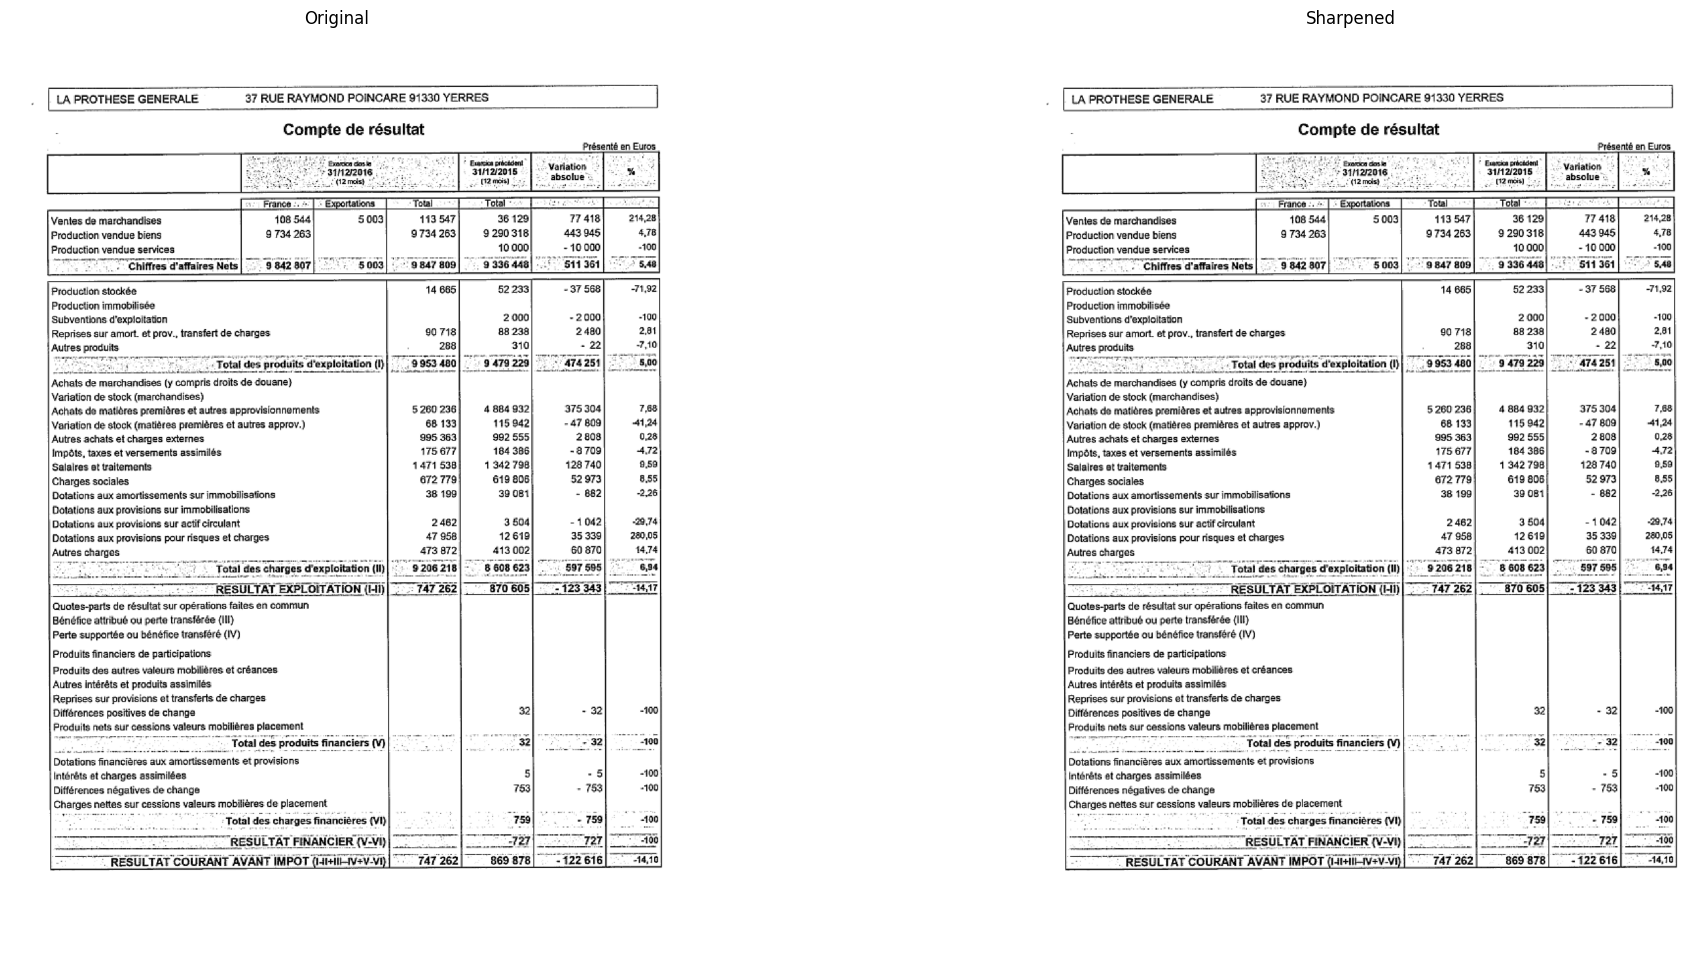

In [125]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def sharpen_laplacian(image):
    """Augmente la netteté en ajoutant les bords laplaciens."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpened = cv2.convertScaleAbs(gray - 0.3 * laplacian)
    return cv2.cvtColor(sharpened, cv2.COLOR_GRAY2RGB)
def sharpen_kernel(image):
    """Sharpen avec un noyau 3x3 classique."""
    kernel = np.array([
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]
    ])
    return cv2.filter2D(image, -1, kernel)


def sharpen_unsharp_mask(image, alpha=1.5, beta=-0.5, sigma=1.0):
    """Applique un filtre Unsharp Mask pour renforcer la netteté.
    
    Params:
    - image: image numpy uint8 (BGR ou RGB)
    - alpha: poids de l'image originale (typiquement 1.0-2.0)
    - beta: poids négatif de l'image floutée (typiquement -0.5 à -1.0)
    - sigma: écart-type du flou gaussien (typiquement 1.0-2.0)
    """
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma)
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened

def pil_to_cv2(pil_img):
    """Convertit une image PIL en image OpenCV (numpy array BGR)."""
    if pil_img.mode == "RGBA":
        pil_img = pil_img.convert("RGB")  # Supprime l'alpha si présent
    cv_img = np.array(pil_img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

def cv2_to_pil(cv_img):
    """Convertit une image OpenCV (numpy array BGR) en image PIL RGB."""
    cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(cv_img_rgb)

def show_images_side_by_side(img1, img2, title1="Original", title2="Sharpened"):
    """Affiche 2 images PIL côte à côte pour comparaison."""
    plt.figure(figsize=(24,12))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(title2)
    plt.axis('off')
    plt.show()

# --- UTILISATION ---

#image_path = "ton_image.png"  # <-- remplace par ton chemin d'image
pil_img = Image.open("input/"+image_path).convert("RGB")

cv_img = pil_to_cv2(pil_img)
alpha= 1.5
sharpened_cv_img = sharpen_unsharp_mask(cv_img, alpha=alpha, beta=1-alpha, sigma=2)
alpha= 1.6
sharpened_cv_img_2 = sharpen_unsharp_mask(cv_img, alpha=alpha, beta=1-alpha, sigma=2)

#sharpened_cv_img = sharpen_laplacian(sharpened_cv_img)
#sharpened_cv_img_2 = sharpen_kernel(sharpened_cv_img)

sharpened_pil = cv2_to_pil(sharpened_cv_img)
sharpened_pil_2 = cv2_to_pil(sharpened_cv_img_2)


show_images_side_by_side(sharpened_cv_img_2, sharpened_pil)


In [152]:
json_path = "output/json/safe_input_res.json" 
with open(json_path, "r", encoding="utf-8") as f:
    json_res = json.load(f)

In [157]:
json_res['table_res_list'][0]['table_ocr_pred'].keys()

dict_keys(['rec_polys', 'rec_texts', 'rec_scores', 'rec_boxes'])

In [159]:
json_res['table_res_list'][0]['table_ocr_pred']['rec_boxes'][0]

[633, 121, 717, 134]

In [181]:
json_res['parsing_res_list']

KeyError: 'layout'